## Amazon Fine Food Review Analysis _ KNN _ KD-Tree

In [2]:
# Getting all the imports done

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os



C:\Users\NamrataT\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
# using SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\NamrataT\Desktop\EXAM\PYTHON\Amazon Fine Food Reviews\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 70000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (70000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
filtered_data['Score'].value_counts()

1    58605
0    11395
Name: Score, dtype: int64

In [5]:
demo_positive = filtered_data[filtered_data['Score']==1]
demo_negetive = filtered_data[filtered_data['Score']==0]

print(demo_positive.shape, demo_negetive.shape)

(58605, 10) (11395, 10)


In [6]:
demo_positive = demo_positive[0:9000]
demo_negetive = demo_negetive[0:11395]
print(demo_positive.shape, demo_negetive.shape)

(9000, 10) (11395, 10)


In [7]:
filtered_data = pd.DataFrame(np.vstack((demo_positive,demo_negetive)),columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'])
print(filtered_data.shape)
print(type(filtered_data))

(20395, 10)
<class 'pandas.core.frame.DataFrame'>


In [8]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.reset_index(drop=True, inplace=True)

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(18870, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.52267712674676

In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(18870, 10)


0    10263
1     8607
Name: Score, dtype: int64

In [13]:
final_score = final['Score']
type(final_score)

pandas.core.series.Series

In [14]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [16]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 18870/18870 [00:12<00:00, 1452.57it/s]


In [17]:
preprocessed_reviews[1500]

'dressing became instant favorite mine fat free without losing flavor alot dresings lose alot flavor fat free versions makes use twice much wish bone choice ranch dressing husband not usually go fat free diet anything put salads didnt even know'

## 2) Applying KNN Kd-Tree

## 2.1) Applying KNN kd_tree on BOW, SET 5

In [18]:
# Getting all the imports done

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
#from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from plotly.plotly import plotly as py
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import resample
from scipy.sparse import hstack

In [19]:
final['Cleaned_Text']=preprocessed_reviews
final['Word Count'] = final['Cleaned_Text'].apply(lambda x:len(x.split()))
final_review = final[['Cleaned_Text','Score','Word Count']]
X = final_review.drop(['Score'],axis=1)
Y = final_review['Score']

In [20]:
# Please write all the code with proper documentation
# TIME BASED SPILTTING
# SIMPLE CROSS VALIDATION

X_1, X_test, Y_1, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False )
X_1_train, X_1_cv, Y_1_train, Y_1_cv = train_test_split( X_1, Y_1, test_size=0.2,shuffle = False)


In [21]:
print(X_1_train.shape,Y_1_train.shape)

(12076, 2) (12076,)


In [22]:
df_post_split = pd.concat([X_1_train,Y_1_train],axis=1)
x_positive = df_post_split[df_post_split['Score']==1]
x_negetive = df_post_split[df_post_split['Score']==0]

In [23]:
df_post_split['Score'].value_counts()

0    6310
1    5766
Name: Score, dtype: int64

In [24]:
# Indicies of each class' observations
i_class0 = np.where(df_post_split['Score'] == 0)[0]
i_class1 = np.where(df_post_split['Score'] == 1)[0]

In [25]:
# For every observation of class 1, randomly sample from class 0 without replacement
#x_negetive_upsample = resample(x_negetive, replace = True, n_samples=17000)
x_negetive_downsample = resample(x_negetive,replace=False,n_samples=4000,random_state=123) 

In [26]:
print(x_negetive_downsample.shape, type(x_positive))

(4000, 3) <class 'pandas.core.frame.DataFrame'>


In [27]:
#df_upsample = pd.concat([x_positive,x_negetive_upsample])
df_upsample = pd.concat([x_positive,x_negetive_downsample])
type(df_upsample)

pandas.core.frame.DataFrame

In [28]:
df_upsample.head()

,Cleaned_Text,Word Count,Score
0,really good idea final product outstanding use...,17,1
1,received shipment could hardly wait try produc...,39,1
2,winter fresh blueberries exceed food budget dr...,27,1
3,like strong smooth flavorful coffee tried othe...,17,1
4,mae ploy sweet chili sauce becoming standard c...,29,1


In [29]:
df_upsample['Score'].value_counts()

1    5766
0    4000
Name: Score, dtype: int64

In [39]:
X_Train = df_upsample.drop(['Score'],axis=1)
Y_Train = df_upsample['Score']
print(X_Train.shape, Y_Train.shape)

(9766, 2) (9766,)


In [103]:
# Applying BOW for Vectorization
# BoW -- fit_transform on D_Train
count_vect = CountVectorizer(max_features=500,min_df=10) #in scikit-learn
D_Train = count_vect.fit_transform(X_Train['Cleaned_Text'])
print(" some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

print("the type of count vectorizer ",type(D_Train))
print("the shape of BOW vectorizer ",D_Train.get_shape())
print("the number of unique words ", D_Train.get_shape()[1])

 some feature names  ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (9766, 500)
the number of unique words  500


In [104]:
print(Y_test.value_counts())

0    2196
1    1578
Name: Score, dtype: int64


In [105]:
# BoW -- transform on D_CV

D_Cv = count_vect.transform(X_1_cv['Cleaned_Text'])
print("the type of count vectorizer ",type(D_Cv))
print("the shape of BOW vectorizer ",D_Cv.get_shape())
print("the number of unique words ", D_Cv.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (3020, 500)
the number of unique words  500


In [106]:
# BoW -- transform on D_Test

D_Test = count_vect.transform(X_test['Cleaned_Text'])
print("the type of count vectorizer ",type(D_Test))
print("the shape of BOW vectorizer ",D_Test.get_shape())
print("the number of unique words ", D_Test.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (3774, 500)
the number of unique words  500


In [85]:
'''X_Train_count  =  X_Train['Word Count'].values.reshape(-1,1)
X_Test_count = X_test['Word Count'].values.reshape(-1,1)'''

In [86]:
'''X_Cv_count  =  X_1_cv['Word Count'].values.reshape(-1,1)'''

In [87]:
'''#standardising word count feature
import warnings
warnings.filterwarnings('ignore')
word_scalar = StandardScaler()
word_scalar.fit(X_Train_count) 
X_Train_count = word_scalar.transform(X_Train_count)
X_Cv_count = word_scalar.transform(X_Cv_count)
X_Test_count = word_scalar.transform(X_Test_count)'''

In [88]:
'''D_Train = hstack((D_Train,X_Train_count))
D_Cv = hstack((D_Cv,X_Cv_count))
D_Test = hstack((D_Test,X_Test_count))'''

In [107]:

n_cv = D_Cv.get_shape()[0]
n_train = D_Train.get_shape()[0]
n_test = D_Test.get_shape()[0]
print(n_train)
print(n_cv)
print(n_test)


9766
3020
3774


In [108]:
# Standardization Process
# Changes done as suggested

scaler = StandardScaler(with_mean=False)
scaler.fit(D_Train)
D_Train = scaler.transform(D_Train)
D_Cv = scaler.transform(D_Cv)
D_Test = scaler.transform(D_Test)

print(D_Train.shape)
print(D_Cv.shape)
print(D_Test.shape)


(9766, 500)
(3020, 500)
(3774, 500)


In [90]:
# Standardization Process  when we are doing Feature Engineering

from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(D_Train)
D_Train = scaler.transform(D_Train)
D_Test = scaler.transform(D_Test)
D_Cv = scaler.transform(D_Cv)
print(D_Train.shape)
print(D_Test.shape)
print(D_Cv.shape)

(9766, 501)
(3774, 501)
(3020, 501)


In [109]:
D_Train = D_Train.toarray()
D_Cv = D_Cv.toarray()
D_Test = D_Test.toarray()
print(type(D_Train))

<class 'numpy.ndarray'>


In [110]:
D_Train=D_Train.astype('int')
D_Cv=D_Cv.astype('int')
D_Test=D_Test.astype('int')
Y_Train=Y_Train.astype('int')
Y_1_cv=Y_1_cv.astype('int')
Y_test=Y_test.astype('int')

In [111]:
# Applying Brute Force KNN

cv_score = []
train_score = []

# creating odd list of K for KNN
myList = list(range(0,50))
neighbours = list(filter(lambda x: x % 2 != 0, myList))


cv_auc = []
train_auc = []
cv_score = []
train_score = []
for i in tqdm(neighbours):
    knn = KNeighborsClassifier(n_neighbors = i,algorithm = 'kd_tree')
    
    predicted_labels_cv = []
    predicted_labels_train = []
    predict_cv_prob = []
    predict_train_prob = []
    accuracy_cv = []
    auc_score_cv = []
    auc_score_train = []
    accuracy_train = []
    
    # Fitting the model in Train - CrossValidation
    knn.fit(D_Train,Y_Train)
    
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_cv.extend(knn.predict(D_Cv[j:j+1000]))
        predict_cv_prob.extend(knn.predict_proba(D_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(knn.predict(D_Train[k:k+1000]))
        predict_train_prob.extend(knn.predict_proba(D_Train[k:k+1000])[:,1])
    
    print(len(predict_cv_prob))
    print(len(Y_1_cv))
    
    # Getting the Cross-Validation Accuracy and AUC Score
    auc_score_cv = roc_auc_score(Y_1_cv,predict_cv_prob)
    accuracy_cv = accuracy_score(Y_1_cv,predicted_labels_cv,normalize=True)* float(100)
    print('\nCV Accuracy for k = %d is %d%%' % (i,accuracy_cv))
    print('\nCV AUC for k = %d is %f%%' % (i,auc_score_cv))
    cv_score.append(accuracy_cv)
    cv_auc.append(auc_score_cv)
    
    # Getting the Training Accuracy and AUC Score
    auc_score_train = roc_auc_score(Y_Train,predict_train_prob)
    accuracy_train = accuracy_score(Y_Train,predicted_labels_train, normalize=True)* float(100)
    print('\nTrain Accuracy for k = %d is %d%%' % (i,accuracy_train))
    print('\nTrain AUC for k = %d is %f%%' % (i,auc_score_train))
    train_score.append(accuracy_train)
    train_auc.append(auc_score_train)

print(cv_auc)
print(train_auc)


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

3020
3020

CV Accuracy for k = 1 is 61%

CV AUC for k = 1 is 0.630204%

Train Accuracy for k = 1 is 99%

Train AUC for k = 1 is 0.999125%



  4%|███▏                                                                            | 1/25 [02:48<1:07:26, 168.60s/it]

3020
3020

CV Accuracy for k = 3 is 61%

CV AUC for k = 3 is 0.687365%

Train Accuracy for k = 3 is 83%

Train AUC for k = 3 is 0.910565%



  8%|██████▍                                                                         | 2/25 [07:10<1:15:20, 196.56s/it]

3020
3020

CV Accuracy for k = 5 is 61%

CV AUC for k = 5 is 0.710955%

Train Accuracy for k = 5 is 79%

Train AUC for k = 5 is 0.878127%



 12%|█████████▌                                                                      | 3/25 [11:33<1:19:25, 216.62s/it]

3020
3020

CV Accuracy for k = 7 is 59%

CV AUC for k = 7 is 0.721925%

Train Accuracy for k = 7 is 76%

Train AUC for k = 7 is 0.860858%



 16%|████████████▊                                                                   | 4/25 [15:57<1:20:45, 230.75s/it]

3020
3020

CV Accuracy for k = 9 is 60%

CV AUC for k = 9 is 0.733018%

Train Accuracy for k = 9 is 75%

Train AUC for k = 9 is 0.847333%



 20%|████████████████                                                                | 5/25 [20:22<1:20:21, 241.06s/it]

3020
3020

CV Accuracy for k = 11 is 59%

CV AUC for k = 11 is 0.735551%

Train Accuracy for k = 11 is 74%

Train AUC for k = 11 is 0.831828%



 24%|███████████████████▏                                                            | 6/25 [24:46<1:18:32, 248.00s/it]

3020
3020

CV Accuracy for k = 13 is 58%

CV AUC for k = 13 is 0.733646%

Train Accuracy for k = 13 is 72%

Train AUC for k = 13 is 0.818481%



 28%|██████████████████████▍                                                         | 7/25 [29:10<1:15:46, 252.59s/it]

3020
3020

CV Accuracy for k = 15 is 58%

CV AUC for k = 15 is 0.732888%

Train Accuracy for k = 15 is 71%

Train AUC for k = 15 is 0.804405%



 32%|█████████████████████████▌                                                      | 8/25 [33:34<1:12:32, 256.00s/it]

3020
3020

CV Accuracy for k = 17 is 57%

CV AUC for k = 17 is 0.732565%

Train Accuracy for k = 17 is 70%

Train AUC for k = 17 is 0.793003%



 36%|████████████████████████████▊                                                   | 9/25 [38:03<1:09:18, 259.89s/it]

3020
3020

CV Accuracy for k = 19 is 56%

CV AUC for k = 19 is 0.732010%

Train Accuracy for k = 19 is 69%

Train AUC for k = 19 is 0.782350%



 40%|███████████████████████████████▌                                               | 10/25 [42:57<1:07:32, 270.17s/it]

3020
3020

CV Accuracy for k = 21 is 55%

CV AUC for k = 21 is 0.729292%

Train Accuracy for k = 21 is 69%

Train AUC for k = 21 is 0.774030%



 44%|██████████████████████████████████▊                                            | 11/25 [47:31<1:03:19, 271.38s/it]

3020
3020

CV Accuracy for k = 23 is 54%

CV AUC for k = 23 is 0.726545%

Train Accuracy for k = 23 is 68%

Train AUC for k = 23 is 0.766619%



 48%|██████████████████████████████████████▉                                          | 12/25 [51:58<58:31, 270.13s/it]

3020
3020

CV Accuracy for k = 25 is 54%

CV AUC for k = 25 is 0.731459%

Train Accuracy for k = 25 is 67%

Train AUC for k = 25 is 0.764803%



 52%|██████████████████████████████████████████                                       | 13/25 [56:30<54:06, 270.53s/it]

3020
3020

CV Accuracy for k = 27 is 53%

CV AUC for k = 27 is 0.739366%

Train Accuracy for k = 27 is 67%

Train AUC for k = 27 is 0.770047%



 56%|████████████████████████████████████████████▏                                  | 14/25 [1:01:01<49:39, 270.84s/it]

3020
3020

CV Accuracy for k = 29 is 53%

CV AUC for k = 29 is 0.746090%

Train Accuracy for k = 29 is 67%

Train AUC for k = 29 is 0.777213%



 60%|███████████████████████████████████████████████▍                               | 15/25 [1:05:29<44:59, 269.95s/it]

3020
3020

CV Accuracy for k = 31 is 52%

CV AUC for k = 31 is 0.753648%

Train Accuracy for k = 31 is 66%

Train AUC for k = 31 is 0.786749%



 64%|██████████████████████████████████████████████████▌                            | 16/25 [1:10:00<40:32, 270.26s/it]

3020
3020

CV Accuracy for k = 33 is 51%

CV AUC for k = 33 is 0.759348%

Train Accuracy for k = 33 is 65%

Train AUC for k = 33 is 0.793622%



 68%|█████████████████████████████████████████████████████▋                         | 17/25 [1:14:27<35:54, 269.35s/it]

3020
3020

CV Accuracy for k = 35 is 51%

CV AUC for k = 35 is 0.761969%

Train Accuracy for k = 35 is 65%

Train AUC for k = 35 is 0.801274%



 72%|████████████████████████████████████████████████████████▉                      | 18/25 [1:18:53<31:18, 268.30s/it]

3020
3020

CV Accuracy for k = 37 is 50%

CV AUC for k = 37 is 0.767588%

Train Accuracy for k = 37 is 65%

Train AUC for k = 37 is 0.807037%



 76%|████████████████████████████████████████████████████████████                   | 19/25 [1:23:22<26:51, 268.61s/it]

3020
3020

CV Accuracy for k = 39 is 50%

CV AUC for k = 39 is 0.770712%

Train Accuracy for k = 39 is 65%

Train AUC for k = 39 is 0.810693%



 80%|███████████████████████████████████████████████████████████████▏               | 20/25 [1:27:52<22:24, 268.92s/it]

3020
3020

CV Accuracy for k = 41 is 50%

CV AUC for k = 41 is 0.770700%

Train Accuracy for k = 41 is 64%

Train AUC for k = 41 is 0.814098%



 84%|██████████████████████████████████████████████████████████████████▎            | 21/25 [1:32:20<17:54, 268.75s/it]

3020
3020

CV Accuracy for k = 43 is 50%

CV AUC for k = 43 is 0.773356%

Train Accuracy for k = 43 is 64%

Train AUC for k = 43 is 0.815392%



 88%|█████████████████████████████████████████████████████████████████████▌         | 22/25 [1:36:51<13:27, 269.17s/it]

3020
3020

CV Accuracy for k = 45 is 49%

CV AUC for k = 45 is 0.774265%

Train Accuracy for k = 45 is 64%

Train AUC for k = 45 is 0.818173%



 92%|████████████████████████████████████████████████████████████████████████▋      | 23/25 [1:41:20<08:58, 269.24s/it]

3020
3020

CV Accuracy for k = 47 is 49%

CV AUC for k = 47 is 0.771367%

Train Accuracy for k = 47 is 64%

Train AUC for k = 47 is 0.820746%



 96%|███████████████████████████████████████████████████████████████████████████▊   | 24/25 [1:45:46<04:28, 268.38s/it]

3020
3020

CV Accuracy for k = 49 is 49%

CV AUC for k = 49 is 0.773985%

Train Accuracy for k = 49 is 63%

Train AUC for k = 49 is 0.822863%



100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [1:50:16<00:00, 268.89s/it]


[0.6302035382956355, 0.6873650066626379, 0.7109552965606187, 0.7219251035671813, 0.7330181592372733, 0.7355507277529402, 0.7336456684291, 0.732888151049236, 0.7325645951427859, 0.7320098634981621, 0.7292923093284592, 0.726544562615954, 0.7314594128857266, 0.73936580338526, 0.74609040368331, 0.7536484533531973, 0.7593478591008661, 0.761968977387588, 0.7675883954285786, 0.7707124223386964, 0.7706995792421311, 0.7733562976912619, 0.774265453737589, 0.7713667443110716, 0.7739849334705066]
[0.9991249999999999, 0.9105653832813042, 0.8781274280263613, 0.8608582856399585, 0.8473327480055499, 0.8318282171349289, 0.8184807492195629, 0.8044049384321887, 0.793002579778009, 0.7823503078390567, 0.7740299817898022, 0.7666192551161984, 0.7648029396462019, 0.7700471730835935, 0.7772130809920222, 0.786748807665626, 0.7936218782518211, 0.8012741718695803, 0.8070368973291709, 0.8106934399930628, 0.8140981616371835, 0.8153915842872008, 0.8181728668054111, 0.8207461628511967, 0.8228630766562609]


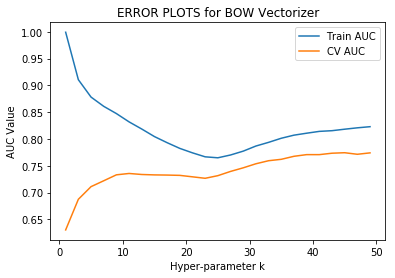

In [112]:
# Plotting Train_AUC and CV_AUC against K
plt.plot(neighbours,train_auc)
plt.plot(neighbours,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for BOW Vectorizer")
plt.xlabel('Hyper-parameter k')
plt.ylabel('AUC Value')
plt.show()

In [113]:
# Getting the optimal K Based to CV AUC
optimal_k_auc = neighbours[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best K = %d' % optimal_k_auc)
print(best_cv_auc)

AUC Metric Best K = 45
0.774


In [120]:
# Applying Best K on D_Test

test_neigh = KNeighborsClassifier(n_neighbors = 10 ,algorithm = 'kd_tree')
test_neigh.fit(D_Train,Y_Train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_Train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)


3774
3774
Algo Run Successfully on D_Test


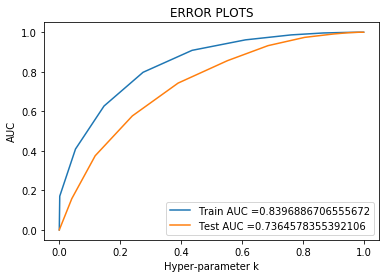

In [121]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyper-parameter k")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [122]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_Train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_Train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
2255 1745 528 5238
[[2255 1745]
 [ 528 5238]]
Test Confusion Matrix
983 1213 227 1351
[[ 983 1213]
 [ 227 1351]]


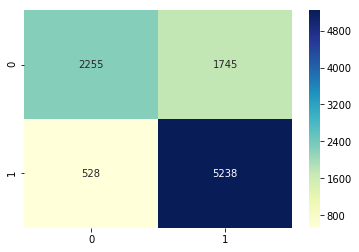

In [123]:
import seaborn as sns
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

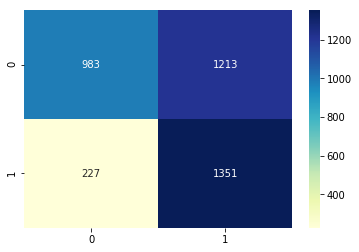

In [124]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

## 2.2) Applying KNN kd-tree on TFIDF, SET 5

In [40]:
# Applying BOW for Vectorization
# BoW -- fit_transform on D2_Train

tfidf_vect = TfidfVectorizer(max_features=500,min_df=10) #in scikit-learn
D2_Train = tfidf_vect.fit_transform(X_Train['Cleaned_Text'])
print(" some feature names ", tfidf_vect.get_feature_names()[:10])
print('='*50)

print("the type of count vectorizer ",type(D2_Train))
print("the shape of BOW vectorizer ",D2_Train.get_shape())

 some feature names  ['able', 'absolutely', 'acid', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'also']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (9766, 500)


In [41]:
# BoW -- transform on D2_CV

D2_Cv = tfidf_vect.transform(X_1_cv['Cleaned_Text'])
print("the type of count vectorizer ",type(D2_Cv))
print("the shape of BOW vectorizer ",D2_Cv.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (3020, 500)


In [42]:
# BoW -- transform on D2_Test

D2_Test = tfidf_vect.transform(X_test['Cleaned_Text'])
print("the type of count vectorizer ",type(D2_Test))
print("the shape of BOW vectorizer ",D2_Test.get_shape())

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (3774, 500)


In [43]:
n_cv = D2_Cv.get_shape()[0]
n_train = D2_Train.get_shape()[0]
n_test = D2_Test.get_shape()[0]
print(n_train)
print(n_cv)
print(n_test)

9766
3020
3774


In [44]:
# Standardization Process
# Changes done as suggested

scaler = StandardScaler(with_mean=False)
scaler.fit(D2_Train)
D2_Train = scaler.transform(D2_Train)
D2_Cv = scaler.transform(D2_Cv)
D2_Test = scaler.transform(D2_Test)

print(D2_Train.shape)
print(D2_Cv.shape)
print(D2_Test.shape)

(9766, 500)
(3020, 500)
(3774, 500)


In [45]:
D2_Train = D2_Train.toarray()
D2_Cv = D2_Cv.toarray()
D2_Test = D2_Test.toarray()
print(type(D2_Train))

<class 'numpy.ndarray'>


In [46]:
D2_Train=D2_Train.astype('int')
D2_Cv=D2_Cv.astype('int')
D2_Test=D2_Test.astype('int')
Y_Train=Y_Train.astype('int')
Y_1_cv=Y_1_cv.astype('int')
Y_test=Y_test.astype('int')

In [47]:
# Applying Brute Force KNN

cv_score = []
train_score = []

# creating odd list of K for KNN
myList = list(range(0,20))
neighbours = list(filter(lambda x: x % 2 != 0, myList))


cv_auc = []
train_auc = []
cv_score = []
train_score = []
for i in tqdm(neighbours):
    knn = KNeighborsClassifier(n_neighbors = i,algorithm = 'kd_tree')
    
    predicted_labels_cv = []
    predicted_labels_train = []
    predict_cv_prob = []
    predict_train_prob = []
    accuracy_cv = []
    auc_score_cv = []
    auc_score_train = []
    accuracy_train = []
    
    # Fitting the model in Train - CrossValidation
    knn.fit(D2_Train,Y_Train)
    
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_cv.extend(knn.predict(D2_Cv[j:j+1000]))
        predict_cv_prob.extend(knn.predict_proba(D2_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(knn.predict(D2_Train[k:k+1000]))
        predict_train_prob.extend(knn.predict_proba(D2_Train[k:k+1000])[:,1])
    
    print(len(predict_cv_prob))
    print(len(Y_1_cv))
    
    # Getting the Cross-Validation Accuracy and AUC Score
    auc_score_cv = roc_auc_score(Y_1_cv,predict_cv_prob)
    accuracy_cv = accuracy_score(Y_1_cv,predicted_labels_cv,normalize=True)* float(100)
    print('\nCV Accuracy for k = %d is %d%%' % (i,accuracy_cv))
    print('\nCV AUC for k = %d is %f%%' % (i,auc_score_cv))
    cv_score.append(accuracy_cv)
    cv_auc.append(auc_score_cv)
    
    # Getting the Training Accuracy and AUC Score
    auc_score_train = roc_auc_score(Y_Train,predict_train_prob)
    accuracy_train = accuracy_score(Y_Train,predicted_labels_train, normalize=True)* float(100)
    print('\nTrain Accuracy for k = %d is %d%%' % (i,accuracy_train))
    print('\nTrain AUC for k = %d is %f%%' % (i,auc_score_train))
    train_score.append(accuracy_train)
    train_auc.append(auc_score_train)

print(cv_auc)
print(train_auc)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

3020
3020

CV Accuracy for k = 1 is 52%

CV AUC for k = 1 is 0.567825%

Train Accuracy for k = 1 is 99%

Train AUC for k = 1 is 0.999000%


 10%|████████▏                                                                         | 1/10 [02:22<21:19, 142.18s/it]

3020
3020

CV Accuracy for k = 3 is 51%

CV AUC for k = 3 is 0.588324%

Train Accuracy for k = 3 is 73%

Train AUC for k = 3 is 0.922719%


 20%|████████████████▍                                                                 | 2/10 [06:43<23:44, 178.02s/it]

3020
3020

CV Accuracy for k = 5 is 49%

CV AUC for k = 5 is 0.583431%

Train Accuracy for k = 5 is 68%

Train AUC for k = 5 is 0.889098%


 30%|████████████████████████▌                                                         | 3/10 [11:06<23:44, 203.46s/it]

3020
3020

CV Accuracy for k = 7 is 49%

CV AUC for k = 7 is 0.582882%

Train Accuracy for k = 7 is 66%

Train AUC for k = 7 is 0.872173%


 40%|████████████████████████████████▊                                                 | 4/10 [15:30<22:10, 221.68s/it]

3020
3020

CV Accuracy for k = 9 is 48%

CV AUC for k = 9 is 0.579850%

Train Accuracy for k = 9 is 65%

Train AUC for k = 9 is 0.862930%


 50%|█████████████████████████████████████████                                         | 5/10 [19:54<19:32, 234.41s/it]

3020
3020

CV Accuracy for k = 11 is 48%

CV AUC for k = 11 is 0.578701%

Train Accuracy for k = 11 is 65%

Train AUC for k = 11 is 0.858045%


 60%|█████████████████████████████████████████████████▏                                | 6/10 [24:19<16:13, 243.32s/it]

3020
3020

CV Accuracy for k = 13 is 46%

CV AUC for k = 13 is 0.577538%

Train Accuracy for k = 13 is 65%

Train AUC for k = 13 is 0.854589%


 70%|█████████████████████████████████████████████████████████▍                        | 7/10 [28:46<12:32, 250.68s/it]

3020
3020

CV Accuracy for k = 15 is 45%

CV AUC for k = 15 is 0.577102%

Train Accuracy for k = 15 is 63%

Train AUC for k = 15 is 0.852463%


 80%|█████████████████████████████████████████████████████████████████▌                | 8/10 [33:12<08:30, 255.02s/it]

3020
3020

CV Accuracy for k = 17 is 44%

CV AUC for k = 17 is 0.575997%

Train Accuracy for k = 17 is 62%

Train AUC for k = 17 is 0.851110%


 90%|█████████████████████████████████████████████████████████████████████████▊        | 9/10 [37:37<04:18, 258.25s/it]

3020
3020

CV Accuracy for k = 19 is 44%

CV AUC for k = 19 is 0.575672%

Train Accuracy for k = 19 is 61%

Train AUC for k = 19 is 0.849915%


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [42:04<00:00, 260.77s/it]


[0.5678252942308359, 0.5883240029363375, 0.5834314590974412, 0.5828819097549403, 0.579850037695615, 0.5787006932117701, 0.5775380549963927, 0.5771022909831098, 0.575997334043534, 0.5756717502797316]
[0.999, 0.9227187825182102, 0.8890979882067293, 0.8721731919875131, 0.8629295005202915, 0.8580454171002428, 0.8545886229621922, 0.8524632327436698, 0.8511103884842179, 0.84991501907735]


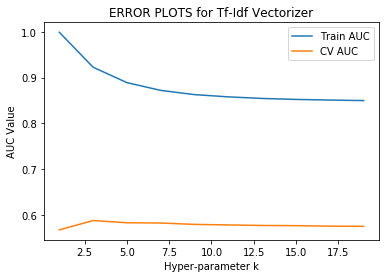

In [48]:
# Plotting Train_AUC and CV_AUC against K
plt.plot(neighbours,train_auc)
plt.plot(neighbours,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for Tf-Idf Vectorizer")
plt.xlabel('Hyper-parameter k')
plt.ylabel('AUC Value')
plt.show()

In [50]:
# Getting the optimal K Based to CV AUC
optimal_k_auc = neighbours[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best K = %d' % optimal_k_auc)
print(best_cv_auc)

AUC Metric Best K = 3
0.588


In [57]:
# Applying Best K on D_Test

test_neigh = KNeighborsClassifier(n_neighbors = 10,algorithm = 'kd_tree')
test_neigh.fit(D2_Train,Y_Train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D2_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D2_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D2_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D2_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_Train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D2_Test')
print("="*100)


3774
3774
Algo Run Successfully on D2_Test


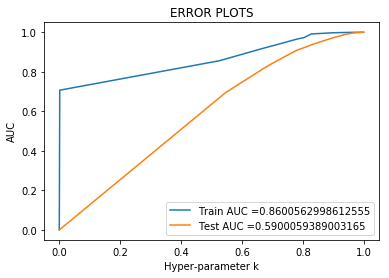

In [58]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyper-parameter k")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [59]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_Train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_Train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
883 3117 203 5563
[[ 883 3117]
 [ 203 5563]]
Test Confusion Matrix
417 1779 118 1460
[[ 417 1779]
 [ 118 1460]]


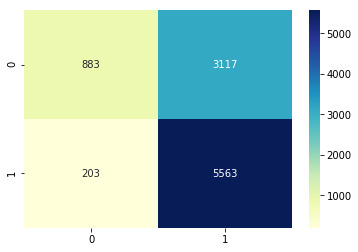

In [107]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

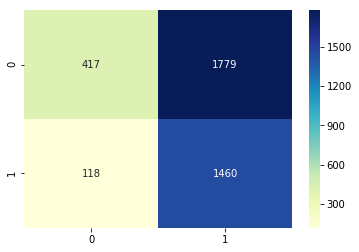

In [109]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

## 2.3) Applying KNN kd-tree on Avg W2V, SET 7

In [60]:
# Applying Word2Vec for Vectorization of X_3_train
# Creating Word2Vec Model

list_of_sentence = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

# Creating Word2Vec model with 50 dimension and min_count=5, it will consider the word only if it appeared more than 5 times

w2v_model = Word2Vec(list_of_sentence, min_count=5, size=50, workers=4)
print(w2v_model.wv.most_similar("good"))
print("="*100)

w2v_words = list(w2v_model.wv.vocab)
print("Total Words Present ", len(w2v_words))
print("Sample Words : ", w2v_words[0:100])
print("="*100)

9766
[('bad', 0.8960937261581421), ('pretty', 0.8885632753372192), ('great', 0.8831590414047241), ('buds', 0.8581732511520386), ('terrible', 0.8581616878509521), ('enjoy', 0.8565393090248108), ('quite', 0.8488548994064331), ('though', 0.848454475402832), ('expecting', 0.8472972512245178), ('expect', 0.8460354804992676)]
Total Words Present  6052
Sample Words :  ['really', 'good', 'idea', 'final', 'product', 'outstanding', 'use', 'car', 'everybody', 'asks', 'bought', 'made', 'two', 'thumbs', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'stickers', 'removed', 'easily', 'daughter', 'designed', 'signs', 'printed', 'windows', 'beautifully', 'print', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'winter', 'fresh', 'blueberries', 'food', 'budget', 'dried', 'blue', 'berries', 'fine', 'muffins', 'breads', 'also', 'enjoy', 'fruit', 'cereal', 'often', 'oatmeal', 'sprinkle', 'bowl', 'wonderful', 'cold', 'morning', 'strong'

In [61]:
# Creating Average Word2Vec Vector for Train Data

sent_vect_train = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_train.append(sentence_vec)
print(len(sent_vect_train))
print(sent_vect_train[0])

100%|█████████████████████████████████████████████████████████████████████████████| 9766/9766 [00:20<00:00, 468.08it/s]


9766
[-0.18980466  0.24759159  0.26317158 -0.09751008 -0.08907756  0.2612138
  0.0916395  -0.30364079 -0.60144179  0.5810043   0.03802499 -0.39164155
 -0.06488616  0.02575865 -0.27491921  0.36913325  0.00678451  0.09669539
 -0.51318604  0.2372777  -0.3850475  -0.08097776  0.20927252  0.05805941
  0.68231439  0.44254473  0.2157993  -0.33328086 -0.05923016  0.0925621
  0.3196539   0.13372497  0.14509976  0.03159371 -0.2338632  -0.12638391
 -0.05035271 -0.5767967  -0.41533071  0.52177755  0.3491946   0.04256844
 -0.04984072  0.32300956 -0.08134938 -0.2822628  -0.5364605   0.53264595
  0.05511893 -0.03812477]


In [62]:
# Applying Word2Vec for Vectorization of X_3_cv
# Creating Word2Vec Model

list_of_sentence = []
for sentence in X_1_cv['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

3020


In [63]:
# Creating Average Word2Vec Model for Cross-Validation Data

sent_vect_cv = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_cv.append(sentence_vec)
print(len(sent_vect_cv))
print(sent_vect_cv[0])

100%|█████████████████████████████████████████████████████████████████████████████| 3020/3020 [00:07<00:00, 421.67it/s]


3020
[-0.32808646  0.45199506  0.60207293 -0.09405019 -0.03349983  0.21065933
  0.20280278 -0.45866056 -0.5701365   0.67545386  0.02023472 -0.47396933
 -0.01252754 -0.00436707 -0.3789183   0.64639208  0.07214022 -0.00224362
 -0.66680512  0.19925537 -0.41926658  0.02550766  0.36232227  0.26115357
  0.93877593  0.31429466  0.42113408 -0.24809775 -0.12840714 -0.00660371
  0.24007963  0.06643914  0.11474299 -0.01534066 -0.21182747 -0.21151725
 -0.0778203  -0.50247778 -0.55385395  0.8040967   0.57741005  0.19063094
  0.05228695  0.42835545  0.02163351 -0.31957279 -0.6863559   0.69611846
 -0.02795565 -0.13177685]


In [64]:
# Applying Word2Vec for Vectorization of X3_test
# Creating Word2Vec Model

list_of_sentence = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

3774


In [65]:
# Creating Average Word2Vec Model for Test Data

sent_vect_test = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_test.append(sentence_vec)
print(len(sent_vect_test))
print(sent_vect_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 3774/3774 [00:08<00:00, 443.67it/s]


3774
[-0.26568009  0.28756032  0.47932307  0.13545598 -0.17569504  0.25563438
 -0.13039685 -0.46757922 -0.69579768  0.55314274 -0.07370989 -0.43050561
  0.08853899 -0.11014491 -0.3152842   0.40995799  0.01780464  0.05823347
 -0.5239293   0.3567474  -0.38367433 -0.06542805  0.22325936  0.40791474
  0.40334683  0.73606301  0.02363223 -0.40862216 -0.13717105 -0.05456789
  0.12610679  0.00610712  0.22944186  0.13475018 -0.28952888 -0.08235817
 -0.07682139 -0.64351284 -0.10371735  0.73341245  0.39251888  0.19038355
  0.18761057  0.34853042 -0.01441942 -0.45105978 -0.69878183  0.53834783
  0.03509503 -0.08708783]


In [66]:
n_cv = len(sent_vect_cv)
n_train = len(sent_vect_train)
n_test = len(sent_vect_test)
print(n_train)
print(n_cv)
print(n_test)

9766
3020
3774


In [67]:
# Standardization Process

scaler = StandardScaler()
scaler.fit(sent_vect_train)
D3_Train = scaler.transform(sent_vect_train)
D3_Cv = scaler.transform(sent_vect_cv)
D3_Test = scaler.transform(sent_vect_test)

print(D3_Train.shape)
print(D3_Cv.shape)
print(D3_Test.shape)

(9766, 50)
(3020, 50)
(3774, 50)


In [68]:
D3_Train=D3_Train.astype('int')
D3_Cv=D3_Cv.astype('int')
D3_Test=D3_Test.astype('int')
Y_Train=Y_Train.astype('int')
Y_1_cv=Y_1_cv.astype('int')
Y_test=Y_test.astype('int')

In [69]:
# Applying Brute Force KNN on Word2Vec Train Model

cv_score = []
train_score = []

# creating odd list of K for KNN
myList = list(range(0,30))
neighbours = list(filter(lambda x: x % 2 != 0, myList))


cv_auc = []
train_auc = []
cv_score = []
train_score = []
for i in tqdm(neighbours):
    knn = KNeighborsClassifier(n_neighbors = i, algorithm = 'kd_tree')
    
    predicted_labels_cv = []
    predicted_labels_train = []
    predict_cv_prob = []
    predict_train_prob = []
    accuracy_cv = []
    auc_score_cv = []
    auc_score_train = []
    accuracy_train = []
    
    # Fitting the model in Train - CrossValidation
    knn.fit(D3_Train,Y_Train)
    
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_cv.extend(knn.predict(D3_Cv[j:j+1000]))
        predict_cv_prob.extend(knn.predict_proba(D3_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(knn.predict(D3_Train[k:k+1000]))
        predict_train_prob.extend(knn.predict_proba(D3_Train[k:k+1000])[:,1])
    
    print(len(predict_cv_prob))
    print(len(Y_1_cv))
    
    # Getting the Cross-Validation Accuracy and AUC Score
    auc_score_cv = roc_auc_score(Y_1_cv,predict_cv_prob)
    accuracy_cv = accuracy_score(Y_1_cv,predicted_labels_cv,normalize=True)* float(100)
    print('\nCV Accuracy for k = %d is %d%%' % (i,accuracy_cv))
    print('\nCV AUC for k = %d is %f%%' % (i,auc_score_cv))
    cv_score.append(accuracy_cv)
    cv_auc.append(auc_score_cv)
    
    # Getting the Training Accuracy and AUC Score
    auc_score_train = roc_auc_score(Y_Train,predict_train_prob)
    accuracy_train = accuracy_score(Y_Train,predicted_labels_train, normalize=True)* float(100)
    print('\nTrain Accuracy for k = %d is %d%%' % (i,accuracy_train))
    print('\nTrain AUC for k = %d is %f%%' % (i,auc_score_train))
    train_score.append(accuracy_train)
    train_auc.append(auc_score_train)

# Misclassification Error ( Cross-Validation Error )
#cv_error = [1 - x for x in cv_score]

# Misclassification Error ( Training Error )
#train_error = [1 - x for x in train_score]  

print(cv_auc)
print(train_auc)

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

3020
3020

CV Accuracy for k = 1 is 53%

CV AUC for k = 1 is 0.561546%

Train Accuracy for k = 1 is 94%

Train AUC for k = 1 is 0.934480%


  7%|█████▌                                                                             | 1/15 [00:20<04:51, 20.83s/it]

3020
3020

CV Accuracy for k = 3 is 54%

CV AUC for k = 3 is 0.605208%

Train Accuracy for k = 3 is 76%

Train AUC for k = 3 is 0.829654%


 13%|███████████                                                                        | 2/15 [00:51<05:10, 23.90s/it]

3020
3020

CV Accuracy for k = 5 is 54%

CV AUC for k = 5 is 0.614033%

Train Accuracy for k = 5 is 73%

Train AUC for k = 5 is 0.779337%


 20%|████████████████▌                                                                  | 3/15 [01:23<05:14, 26.19s/it]

3020
3020

CV Accuracy for k = 7 is 55%

CV AUC for k = 7 is 0.625583%

Train Accuracy for k = 7 is 70%

Train AUC for k = 7 is 0.754368%


 27%|██████████████████████▏                                                            | 4/15 [01:56<05:10, 28.27s/it]

3020
3020

CV Accuracy for k = 9 is 55%

CV AUC for k = 9 is 0.635787%

Train Accuracy for k = 9 is 69%

Train AUC for k = 9 is 0.733174%


 33%|███████████████████████████▋                                                       | 5/15 [02:29<04:57, 29.78s/it]

3020
3020

CV Accuracy for k = 11 is 55%

CV AUC for k = 11 is 0.645218%

Train Accuracy for k = 11 is 69%

Train AUC for k = 11 is 0.720200%


 40%|█████████████████████████████████▏                                                 | 6/15 [03:02<04:36, 30.74s/it]

3020
3020

CV Accuracy for k = 13 is 55%

CV AUC for k = 13 is 0.646294%

Train Accuracy for k = 13 is 68%

Train AUC for k = 13 is 0.712379%


 47%|██████████████████████████████████████▋                                            | 7/15 [03:39<04:20, 32.57s/it]

3020
3020

CV Accuracy for k = 15 is 56%

CV AUC for k = 15 is 0.646057%

Train Accuracy for k = 15 is 68%

Train AUC for k = 15 is 0.706421%


 53%|████████████████████████████████████████████▎                                      | 8/15 [04:15<03:54, 33.45s/it]

3020
3020

CV Accuracy for k = 17 is 56%

CV AUC for k = 17 is 0.644602%

Train Accuracy for k = 17 is 68%

Train AUC for k = 17 is 0.701152%


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [04:50<03:23, 33.97s/it]

3020
3020

CV Accuracy for k = 19 is 56%

CV AUC for k = 19 is 0.644532%

Train Accuracy for k = 19 is 68%

Train AUC for k = 19 is 0.697218%


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [05:26<02:52, 34.59s/it]

3020
3020

CV Accuracy for k = 21 is 56%

CV AUC for k = 21 is 0.645450%

Train Accuracy for k = 21 is 67%

Train AUC for k = 21 is 0.692839%


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [06:00<02:17, 34.49s/it]

3020
3020

CV Accuracy for k = 23 is 56%

CV AUC for k = 23 is 0.643931%

Train Accuracy for k = 23 is 67%

Train AUC for k = 23 is 0.689085%


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [06:35<01:43, 34.46s/it]

3020
3020

CV Accuracy for k = 25 is 56%

CV AUC for k = 25 is 0.645492%

Train Accuracy for k = 25 is 67%

Train AUC for k = 25 is 0.685258%


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [07:09<01:08, 34.46s/it]

3020
3020

CV Accuracy for k = 27 is 55%

CV AUC for k = 27 is 0.643030%

Train Accuracy for k = 27 is 67%

Train AUC for k = 27 is 0.681757%


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [07:44<00:34, 34.66s/it]

3020
3020

CV Accuracy for k = 29 is 55%

CV AUC for k = 29 is 0.642144%

Train Accuracy for k = 29 is 67%

Train AUC for k = 29 is 0.679943%


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [08:19<00:00, 34.87s/it]


[0.5615461465978637, 0.6052077179349562, 0.6140334037675786, 0.6255829526594447, 0.6357866802217664, 0.6452177941328229, 0.6462943610694649, 0.6460573270767173, 0.6446020014501432, 0.64453170239526, 0.6454496458234475, 0.6439314566189489, 0.6454924561453316, 0.6430299613670643, 0.6421442383390316]
[0.9344797086368365, 0.8296544181408254, 0.7793370620881027, 0.7543675208116546, 0.7331741892126257, 0.7202001170655568, 0.712378772112383, 0.706421457682969, 0.701151664932362, 0.6972178720083246, 0.6928390348595214, 0.6890854361775928, 0.6852575442247659, 0.6817566337148803, 0.679943418314256]


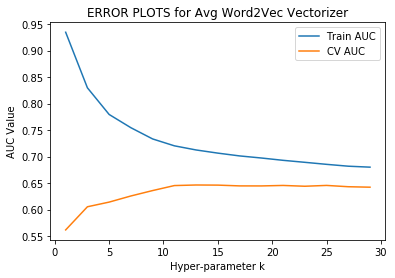

In [70]:
# Plotting Train_AUC and CV_AUC against K
plt.plot(neighbours,train_auc)
plt.plot(neighbours,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for Avg Word2Vec Vectorizer")
plt.xlabel('Hyper-parameter k')
plt.ylabel('AUC Value')
plt.show()

In [72]:
# Getting the optimal K Based to CV AUC
optimal_k_auc = neighbours[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best K = %d' % optimal_k_auc)
print(best_cv_auc)

AUC Metric Best K = 13
0.646


In [76]:
# Applying Best K on D_Test

test_neigh = KNeighborsClassifier(n_neighbors =7,algorithm = 'kd_tree')
test_neigh.fit(D3_Train,Y_Train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D3_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D3_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D3_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D3_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_Train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D3_Test')
print("="*100)

3774
3774
Algo Run Successfully on D3_Test


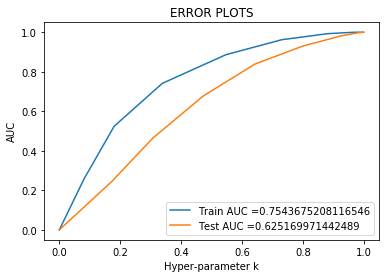

In [77]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyper-parameter k")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [78]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_Train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_Train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
1810 2190 655 5111
[[1810 2190]
 [ 655 5111]]
Test Confusion Matrix
784 1412 254 1324
[[ 784 1412]
 [ 254 1324]]


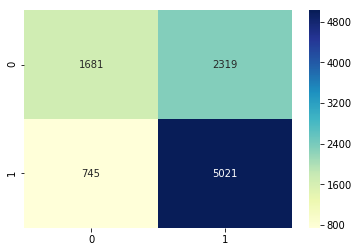

In [49]:
import seaborn as sns
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

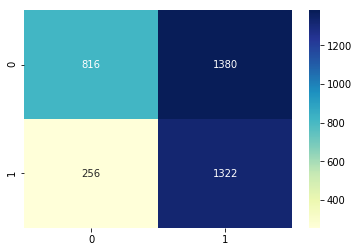

In [50]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

 ## 2.4) Applying KNN kd-tree on Tf-Idf Weighted Avg W2V, SET 8

We are using the previous splitting and the Word2Vec Model here. We are not training the Word2Vec Model again here.

In [80]:
# Splitting the Training Data into sentences
list_of_sentence = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

9766


In [81]:
# Tf-Idf Weighted Word2Vec for Training Data

tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_train = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_train.append(sent_vec)
print(len(tfidf_w2v_train))

100%|█████████████████████████████████████████████████████████████████████████████| 9766/9766 [00:24<00:00, 404.75it/s]


9766


In [86]:
# Splitting the Cross-Validation Data into sentences

list_of_sentence = []
for sentence in X_1_cv['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

3020


In [87]:
# Tf-Idf Weighted Word2Vec for Cross-Validation Data

tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_cv = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_cv.append(sent_vec)
print(len(tfidf_w2v_cv))

100%|█████████████████████████████████████████████████████████████████████████████| 3020/3020 [00:08<00:00, 361.09it/s]


3020


In [88]:
# Splitting the Test Data into sentences

list_of_sentence = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

3774


In [89]:
# Tf-Idf Weighted Word2Vec for Test Data

tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_test = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_test.append(sent_vec)
print(len(tfidf_w2v_test))

100%|█████████████████████████████████████████████████████████████████████████████| 3774/3774 [00:10<00:00, 365.31it/s]


3774


In [90]:
n_cv = len(tfidf_w2v_cv)
n_train = len(tfidf_w2v_train)
n_test = len(tfidf_w2v_test)
print(n_train)
print(n_cv)
print(n_test)

9766
3020
3774


In [91]:
# Standardization Process

scaler = StandardScaler()
scaler.fit(tfidf_w2v_train)
D3_Train = scaler.transform(tfidf_w2v_train)
D3_Cv = scaler.transform(tfidf_w2v_cv)
D3_Test = scaler.transform(tfidf_w2v_test)

print(D3_Train.shape)
print(D3_Cv.shape)
print(D3_Test.shape)

(9766, 50)
(3020, 50)
(3774, 50)


In [92]:
D3_Train=D3_Train.astype('int')
D3_Cv=D3_Cv.astype('int')
D3_Test=D3_Test.astype('int')
Y_Train=Y_Train.astype('int')
Y_1_cv=Y_1_cv.astype('int')
Y_test=Y_test.astype('int')

In [93]:
# Applying Brute Force KNN on Tf_Idf Weighted Word2Vec Train Model

cv_score = []
train_score = []

# creating odd list of K for KNN
myList = list(range(0,30))
neighbours = list(filter(lambda x: x % 2 != 0, myList))


cv_auc = []
train_auc = []
cv_score = []
train_score = []
for i in tqdm(neighbours):
    knn = KNeighborsClassifier(n_neighbors = i, algorithm = 'kd_tree')
    
    predicted_labels_cv = []
    predicted_labels_train = []
    predict_cv_prob = []
    predict_train_prob = []
    accuracy_cv = []
    auc_score_cv = []
    auc_score_train = []
    accuracy_train = []
    
    # Fitting the model in Train - CrossValidation
    knn.fit(D3_Train,Y_Train)
    
    # Predicting the model with CrossValidation and Train Data
    for j in range(0,n_cv,1000):
        predicted_labels_cv.extend(knn.predict(D3_Cv[j:j+1000]))
        predict_cv_prob.extend(knn.predict_proba(D3_Cv[j:j+1000])[:,1])
    
    for k in range(0,n_train,1000):
        predicted_labels_train.extend(knn.predict(D3_Train[k:k+1000]))
        predict_train_prob.extend(knn.predict_proba(D3_Train[k:k+1000])[:,1])
    
    print(len(predict_cv_prob))
    print(len(Y_1_cv))
    
    # Getting the Cross-Validation Accuracy and AUC Score
    auc_score_cv = roc_auc_score(Y_1_cv,predict_cv_prob)
    accuracy_cv = accuracy_score(Y_1_cv,predicted_labels_cv,normalize=True)* float(100)
    print('\nCV Accuracy for k = %d is %d%%' % (i,accuracy_cv))
    print('\nCV AUC for k = %d is %f%%' % (i,auc_score_cv))
    cv_score.append(accuracy_cv)
    cv_auc.append(auc_score_cv)
    
    # Getting the Training Accuracy and AUC Score
    auc_score_train = roc_auc_score(Y_Train,predict_train_prob)
    accuracy_train = accuracy_score(Y_Train,predicted_labels_train, normalize=True)* float(100)
    print('\nTrain Accuracy for k = %d is %d%%' % (i,accuracy_train))
    print('\nTrain AUC for k = %d is %f%%' % (i,auc_score_train))
    train_score.append(accuracy_train)
    train_auc.append(auc_score_train)

print(cv_auc)
print(train_auc)

  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

3020
3020

CV Accuracy for k = 1 is 51%

CV AUC for k = 1 is 0.549234%

Train Accuracy for k = 1 is 92%

Train AUC for k = 1 is 0.912258%


  7%|█████▌                                                                             | 1/15 [00:18<04:13, 18.11s/it]

3020
3020

CV Accuracy for k = 3 is 52%

CV AUC for k = 3 is 0.576732%

Train Accuracy for k = 3 is 75%

Train AUC for k = 3 is 0.808184%


 13%|███████████                                                                        | 2/15 [00:44<04:28, 20.65s/it]

3020
3020

CV Accuracy for k = 5 is 52%

CV AUC for k = 5 is 0.596314%

Train Accuracy for k = 5 is 71%

Train AUC for k = 5 is 0.781987%


 20%|████████████████▌                                                                  | 3/15 [01:11<04:30, 22.58s/it]

3020
3020

CV Accuracy for k = 7 is 52%

CV AUC for k = 7 is 0.602188%

Train Accuracy for k = 7 is 69%

Train AUC for k = 7 is 0.751271%


 27%|██████████████████████▏                                                            | 4/15 [01:40<04:28, 24.45s/it]

3020
3020

CV Accuracy for k = 9 is 52%

CV AUC for k = 9 is 0.603170%

Train Accuracy for k = 9 is 69%

Train AUC for k = 9 is 0.729857%


 33%|███████████████████████████▋                                                       | 5/15 [02:11<04:24, 26.47s/it]

3020
3020

CV Accuracy for k = 11 is 52%

CV AUC for k = 11 is 0.608930%

Train Accuracy for k = 11 is 68%

Train AUC for k = 11 is 0.713458%


 40%|█████████████████████████████████▏                                                 | 6/15 [02:41<04:07, 27.54s/it]

3020
3020

CV Accuracy for k = 13 is 52%

CV AUC for k = 13 is 0.611123%

Train Accuracy for k = 13 is 68%

Train AUC for k = 13 is 0.701521%


 47%|██████████████████████████████████████▋                                            | 7/15 [03:12<03:48, 28.54s/it]

3020
3020

CV Accuracy for k = 15 is 53%

CV AUC for k = 15 is 0.613850%

Train Accuracy for k = 15 is 67%

Train AUC for k = 15 is 0.693655%


 53%|████████████████████████████████████████████▎                                      | 8/15 [03:44<03:26, 29.51s/it]

3020
3020

CV Accuracy for k = 17 is 52%

CV AUC for k = 17 is 0.614181%

Train Accuracy for k = 17 is 67%

Train AUC for k = 17 is 0.686752%


 60%|█████████████████████████████████████████████████▊                                 | 9/15 [04:16<03:00, 30.12s/it]

3020
3020

CV Accuracy for k = 19 is 52%

CV AUC for k = 19 is 0.613274%

Train Accuracy for k = 19 is 66%

Train AUC for k = 19 is 0.680715%


 67%|██████████████████████████████████████████████████████▋                           | 10/15 [04:45<02:29, 29.96s/it]

3020
3020

CV Accuracy for k = 21 is 52%

CV AUC for k = 21 is 0.612791%

Train Accuracy for k = 21 is 66%

Train AUC for k = 21 is 0.677495%


 73%|████████████████████████████████████████████████████████████▏                     | 11/15 [05:16<02:00, 30.23s/it]

3020
3020

CV Accuracy for k = 23 is 52%

CV AUC for k = 23 is 0.611268%

Train Accuracy for k = 23 is 66%

Train AUC for k = 23 is 0.673383%


 80%|█████████████████████████████████████████████████████████████████▌                | 12/15 [05:48<01:32, 30.71s/it]

3020
3020

CV Accuracy for k = 25 is 52%

CV AUC for k = 25 is 0.611112%

Train Accuracy for k = 25 is 66%

Train AUC for k = 25 is 0.672020%


 87%|███████████████████████████████████████████████████████████████████████           | 13/15 [06:20<01:02, 31.24s/it]

3020
3020

CV Accuracy for k = 27 is 52%

CV AUC for k = 27 is 0.614051%

Train Accuracy for k = 27 is 66%

Train AUC for k = 27 is 0.670389%


 93%|████████████████████████████████████████████████████████████████████████████▌     | 14/15 [06:55<00:32, 32.41s/it]

3020
3020

CV Accuracy for k = 29 is 52%

CV AUC for k = 29 is 0.614487%

Train Accuracy for k = 29 is 66%

Train AUC for k = 29 is 0.668284%


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [07:28<00:00, 32.34s/it]


[0.5492336727065271, 0.5767316437225873, 0.5963144368572537, 0.6021880130197454, 0.6031701719307591, 0.608929737446549, 0.611122977831914, 0.6138497700184444, 0.614181437354304, 0.6132738585303622, 0.6127912284804904, 0.6112676316563854, 0.6111123879101849, 0.6140512038487832, 0.6144865172270988]
[0.912257847728061, 0.8081843999306279, 0.7819868626430801, 0.7512708766909469, 0.7298570716267776, 0.7134581599028789, 0.7015210718002081, 0.6936546782865072, 0.6867522762747139, 0.6807152271938952, 0.6774950789108568, 0.6733825875823793, 0.6720200095386749, 0.670389308012487, 0.6682839923690599]


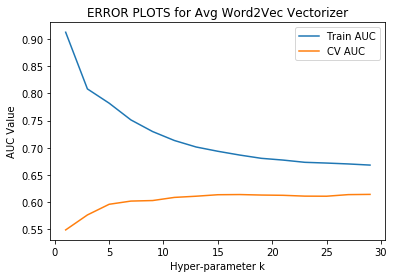

In [94]:
# Plotting Train_AUC and CV_AUC against K
plt.plot(neighbours,train_auc)
plt.plot(neighbours,cv_auc)
plt.legend(['Train AUC', 'CV AUC'], loc='upper right')
plt.title("ERROR PLOTS for Avg Word2Vec Vectorizer")
plt.xlabel('Hyper-parameter k')
plt.ylabel('AUC Value')
plt.show()

In [95]:
# Getting the optimal K Based to CV AUC
optimal_k_auc = neighbours[cv_auc.index(max(cv_auc))]
best_cv_auc = max([ '%.3f' % elem for elem in cv_auc ])
print('AUC Metric Best K = %d' % optimal_k_auc)
print(best_cv_auc)

AUC Metric Best K = 29
0.614


In [99]:
# Applying Best K on D_Test

test_neigh = KNeighborsClassifier(n_neighbors = 10 ,algorithm = 'kd_tree')
test_neigh.fit(D3_Train,Y_Train)

predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

# Predicting the model with CrossValidation and Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D3_Test[j:j+1000]))
    predict_test_prob.extend(test_neigh.predict_proba(D3_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D3_Train[k:k+1000]))
    predict_train_prob.extend(test_neigh.predict_proba(D3_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_Train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D3_Test')
print("="*100)

3774
3774
Algo Run Successfully on D3_Test


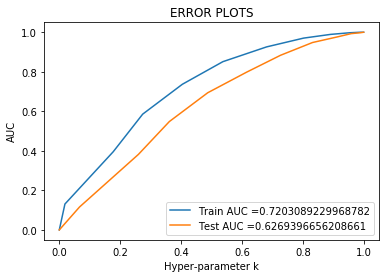

In [100]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyper-parameter k")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [101]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_Train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_Train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
1850 2150 858 4908
[[1850 2150]
 [ 858 4908]]
Test Confusion Matrix
845 1351 319 1259
[[ 845 1351]
 [ 319 1259]]


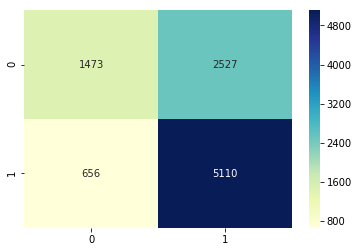

In [82]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

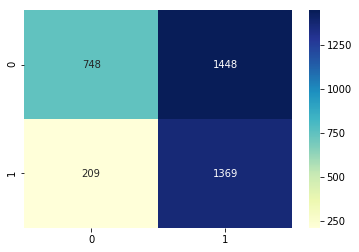

In [83]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")

## Conclusion for Brute Force

In [102]:
# Importing Pretty Table
from prettytable import PrettyTable

In [105]:
x = PrettyTable()
x.field_names = ['Vectorizer', 'Hyper-Parameter Value','AUC']
x.add_row(['BOW','K = 10','0.74'])
x.add_row(['Tf-Idf','K = 10','0.63'])
x.add_row(['Avg Word2Vec','K = 7','0.63'])
x.add_row(['Tf-Idf Weighted Avg Word2Vec','K = 10','0.63'])

print(x)

+------------------------------+-----------------------+------+
|          Vectorizer          | Hyper-Parameter Value | AUC  |
+------------------------------+-----------------------+------+
|             BOW              |         K = 10        | 0.74 |
|            Tf-Idf            |         K = 10        | 0.63 |
|         Avg Word2Vec         |         K = 7         | 0.63 |
| Tf-Idf Weighted Avg Word2Vec |         K = 10        | 0.63 |
+------------------------------+-----------------------+------+


##### From the above table we see that for Amazon Fine Food Review Dataset with 20k datapoints as sample , KNN runs best for BOW Vectorizer  at K = 10 giving AUC value of 0.74 (approx). 

##### We have used Time Based Splitting and Simple Cross-Validation to break the data in Train , CV and Test part. These findings are from KD-Tree KNN Method. 

##### We have tried Feature Engineering on BOW vectorizer but the AUC and confusion matrix is deteorating a lot. So we didnt use it in final version. Same for other vectorizer.